# Hyperparam optimisation of the Wavenet Architecture

Get a better loss than Andrej (on val :))

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../names.txt', 'r') as file:
    names = file.read().splitlines()

len(names)

32033

In [3]:
import random

random.seed(42)
# Shuffle the names to ensure random distribution
random.shuffle(names)

# Calculate split indices
train_split = int(0.8 * len(names))
val_split = int(0.9 * len(names))

# Split the names
train_names = names[:train_split]
val_names = names[train_split:val_split]
test_names = names[val_split:]

print(f"Train set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")
print(f"Test set size: {len(test_names)}")

Train set size: 25626
Validation set size: 3203
Test set size: 3204


In [4]:
chars = sorted(list(set("".join(name for name in names))))
len(chars)

26

In [5]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, ch in enumerate(chars):
    stoi[ch] = i + 1
    itos[i + 1] = ch

len(stoi), len(itos)

(27, 27)

In [6]:
import torch

def create_dataset(names, block_size):
    X, y = [], []

    for name in names:
        name = ['.'] * block_size + list(name) + ['.']

        for i, ch in enumerate(name[block_size:]):
            input_seq = name[i:i+block_size]
            output_seq = ch
            X.append([stoi[c] for c in input_seq])
            y.append(stoi[output_seq])

    X = torch.LongTensor(X)
    y = torch.LongTensor(y)

    return X, y

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out), dtype=torch.float32) * 1 / ((fan_in)**0.50)
        self.bias = bias
        if self.bias:
            self.b = torch.zeros(fan_out). float()
        self.training = True

    def __call__(self, x):
        self.out = x @ self.W
        if self.bias:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])
    
class BatchNorm1d:
    def __init__(self, n_dims, momentum=0.10, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon
        self.training = True

        # learnable params
        self.bngain = torch.ones(n_dims).float()
        self.bnbias = torch.zeros(n_dims).float()

        # running stats
        self.running_mean = torch.zeros(n_dims).float()
        self.running_var = torch.ones(n_dims).float()

    def __call__(self, x):
        if x.ndim == 2:
            dim = 0
        else:
            dim = (0, 1)

        if self.training:
            bnmean = x.mean(dim=dim, keepdim=True)
            bnvar = x.var(dim=dim, keepdim=True)
        else:
            bnmean = self.running_mean
            bnvar = self.running_var

        bnraw = (x - bnmean) / torch.sqrt(bnvar + self.epsilon)
        self.out = self.bngain * bnraw + self.bnbias

        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * bnmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * bnvar + (1 - self.momentum) * self.running_var

        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]
    
class Tanh:
    def __init__(self):
        self.training = True

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.C = torch.randn((num_embeddings, embedding_dim), dtype=torch.float32)
        self.training = True

    def __call__(self, ix):
        self.out = self.C[ix]
        return self.out
    
    def parameters(self):
        return [self.C]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.training = True
        self.n = n
        
    def __call__(self, x):
        B, BS, E = x.shape
        self.out = x.view(B, BS//self.n, E * self.n).squeeze(1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __getitem__(self, idx):
        return self.layers[idx]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(f"{layer.__class__.__name__:30s} | {x.shape}")

        self.out = x
        return self.out
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def train(self):
        for layer in self.layers:
            layer.training = True

        for p in self.parameters():
            p.requires_grad = True

    def eval(self):
        for layer in self.layers:
            layer.training = False

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def update_params(self, lr):
        with torch.no_grad():
            for p in self.parameters():
                p.data -= lr * p.grad
        
    def num_params(self):
        return sum([p.numel() for p in self.parameters()])

## Andrej hyperparams

In [8]:
# Create datasets for training, validation, and test sets
block_size = 8

X_train, y_train = create_dataset(train_names, block_size)
X_val, y_val = create_dataset(val_names, block_size)
X_test, y_test = create_dataset(test_names, block_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: torch.Size([182625, 8]), y_train shape: torch.Size([182625])
X_val shape: torch.Size([22655, 8]), y_val shape: torch.Size([22655])
X_test shape: torch.Size([22866, 8]), y_test shape: torch.Size([22866])


In [11]:
torch.manual_seed(42)

n_embd = 24
hidden_dim = 128
vocab_size = len(stoi)

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 76579


In [12]:
wavenet_model.train()

In [13]:
# training loop

n_iters = 200000
batch_size = 32
lr_scheduler = lambda i: 0.10 if i<150000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.3167154788970947
Step 10000/200000 --> 2.0576295852661133
Step 20000/200000 --> 2.0723233222961426
Step 30000/200000 --> 2.513368606567383
Step 40000/200000 --> 2.1476027965545654
Step 50000/200000 --> 1.7835605144500732
Step 60000/200000 --> 2.259190082550049
Step 70000/200000 --> 1.9330685138702393
Step 80000/200000 --> 1.6874829530715942
Step 90000/200000 --> 2.0394914150238037
Step 100000/200000 --> 1.7735813856124878
Step 110000/200000 --> 1.9569674730300903
Step 120000/200000 --> 1.7464847564697266
Step 130000/200000 --> 1.8125734329223633
Step 140000/200000 --> 1.7405623197555542
Step 150000/200000 --> 1.7466479539871216
Step 160000/200000 --> 1.8805649280548096
Step 170000/200000 --> 1.626599907875061
Step 180000/200000 --> 1.647630214691162
Step 190000/200000 --> 1.855526089668274


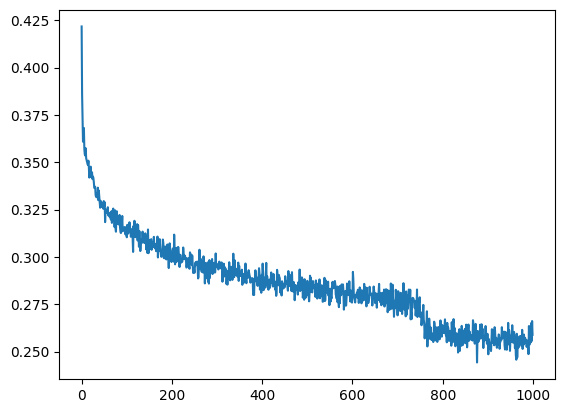

In [16]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [17]:
@torch.no_grad()
def compute_loss(model, X, y):
    logits = model(X)
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

In [18]:
wavenet_model.eval()
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.7658894062042236
Validation Loss: 1.9923888444900513


## Possibility 1: Increase block size and make it 16

In [19]:
# Create datasets for training, validation, and test sets
block_size = 16

X_train, y_train = create_dataset(train_names, block_size)
X_val, y_val = create_dataset(val_names, block_size)
X_test, y_test = create_dataset(test_names, block_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: torch.Size([182625, 16]), y_train shape: torch.Size([182625])
X_val shape: torch.Size([22655, 16]), y_val shape: torch.Size([22655])
X_test shape: torch.Size([22866, 16]), y_test shape: torch.Size([22866])


In [30]:
torch.manual_seed(42)

n_embd = 24
hidden_dim = 128
vocab_size = len(stoi)

wavenet_model1 = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model1[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 109603


In [31]:
wavenet_model1.train()

In [32]:
# training loop

n_iters = 200000
batch_size = 32
lr_scheduler = lambda i: 0.10 if i<150000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model1(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model1.zero_grad()
    loss.backward()
    wavenet_model1.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.272369623184204
Step 10000/200000 --> 2.16459059715271
Step 20000/200000 --> 2.4409608840942383
Step 30000/200000 --> 1.748718500137329
Step 40000/200000 --> 1.9127165079116821
Step 50000/200000 --> 2.0532901287078857
Step 60000/200000 --> 1.7752677202224731
Step 70000/200000 --> 1.8653857707977295
Step 80000/200000 --> 2.246311664581299
Step 90000/200000 --> 1.9517203569412231
Step 100000/200000 --> 2.055762529373169
Step 110000/200000 --> 1.9992039203643799
Step 120000/200000 --> 1.740897297859192
Step 130000/200000 --> 1.6236236095428467
Step 140000/200000 --> 1.7628449201583862
Step 150000/200000 --> 1.7873408794403076
Step 160000/200000 --> 1.467212438583374
Step 170000/200000 --> 1.5955371856689453
Step 180000/200000 --> 1.4849079847335815
Step 190000/200000 --> 1.8699933290481567


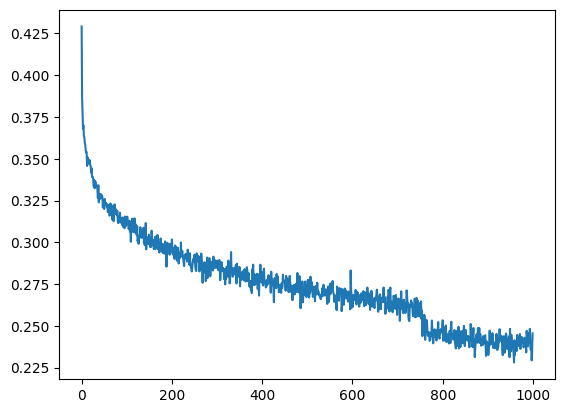

In [33]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [34]:
wavenet_model1.eval()
train_loss = compute_loss(wavenet_model1, X_train, y_train)
val_loss = compute_loss(wavenet_model1, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.704831600189209
Validation Loss: 2.034611225128174


## Possibility 2: Increase no of epochs for Andrej params

In [35]:
# Create datasets for training, validation, and test sets
block_size = 8

X_train, y_train = create_dataset(train_names, block_size)
X_val, y_val = create_dataset(val_names, block_size)
X_test, y_test = create_dataset(test_names, block_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: torch.Size([182625, 8]), y_train shape: torch.Size([182625])
X_val shape: torch.Size([22655, 8]), y_val shape: torch.Size([22655])
X_test shape: torch.Size([22866, 8]), y_test shape: torch.Size([22866])


In [36]:
torch.manual_seed(42)

n_embd = 24
hidden_dim = 128
vocab_size = len(stoi)

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 76579


In [37]:
wavenet_model.train()

In [38]:
# training loop

n_iters = 300000
batch_size = 32
lr_scheduler = lambda i: 0.10 if i<150000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 20000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/300000 --> 3.3167154788970947
Step 20000/300000 --> 2.0723233222961426
Step 40000/300000 --> 2.1476027965545654
Step 60000/300000 --> 2.259190082550049
Step 80000/300000 --> 1.6874829530715942
Step 100000/300000 --> 1.7735813856124878
Step 120000/300000 --> 1.7464847564697266
Step 140000/300000 --> 1.7405623197555542
Step 160000/300000 --> 1.8805649280548096
Step 180000/300000 --> 1.647630214691162
Step 200000/300000 --> 1.8687185049057007
Step 220000/300000 --> 2.093750238418579
Step 240000/300000 --> 1.6730362176895142
Step 260000/300000 --> 1.9550228118896484
Step 280000/300000 --> 1.769331455230713


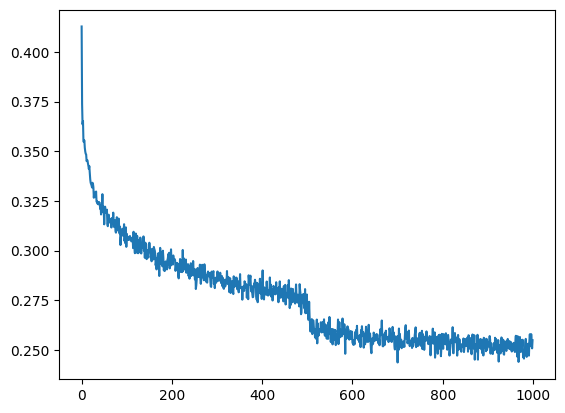

In [39]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [40]:
wavenet_model.eval()
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.7463939189910889
Validation Loss: 1.9993618726730347


## Possibility 3: Slash lr a little quickly

In [41]:
torch.manual_seed(42)

n_embd = 24
hidden_dim = 128
vocab_size = len(stoi)

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 76579


In [42]:
wavenet_model.train()

In [43]:
# training loop

n_iters = 200000
batch_size = 32
lr_scheduler = lambda i: 0.10 if i<100000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 20000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.3167154788970947
Step 20000/200000 --> 2.0723233222961426
Step 40000/200000 --> 2.1476027965545654
Step 60000/200000 --> 2.259190082550049
Step 80000/200000 --> 1.6874829530715942
Step 100000/200000 --> 1.7735813856124878
Step 120000/200000 --> 1.6460156440734863
Step 140000/200000 --> 1.633648157119751
Step 160000/200000 --> 1.8703590631484985
Step 180000/200000 --> 1.6806025505065918


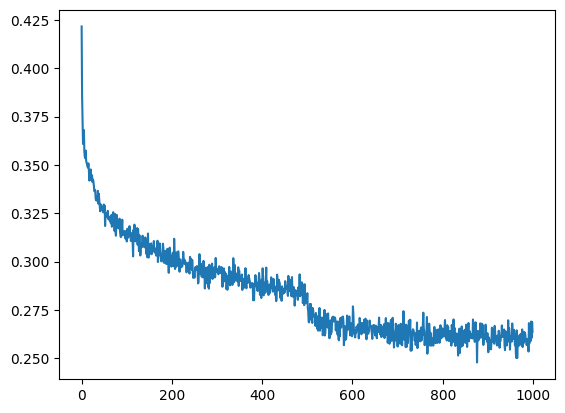

In [44]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [45]:
wavenet_model.eval()
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.7847299575805664
Validation Loss: 1.9904942512512207


## Possibility 4: Increase batch size

In [71]:
torch.manual_seed(42)

n_embd = 24
hidden_dim = 128
vocab_size = len(stoi)

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 76579


In [72]:
wavenet_model.train()

In [73]:
# training loop

n_iters = 200000
batch_size = 16
lr_scheduler = lambda i: 0.10 if i<100000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 20000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.3216612339019775
Step 20000/200000 --> 1.9847193956375122
Step 40000/200000 --> 2.1698482036590576
Step 60000/200000 --> 2.712212324142456
Step 80000/200000 --> 2.0784904956817627
Step 100000/200000 --> 1.6553568840026855
Step 120000/200000 --> 2.184929132461548
Step 140000/200000 --> 2.0838027000427246
Step 160000/200000 --> 1.5948662757873535
Step 180000/200000 --> 2.201033353805542


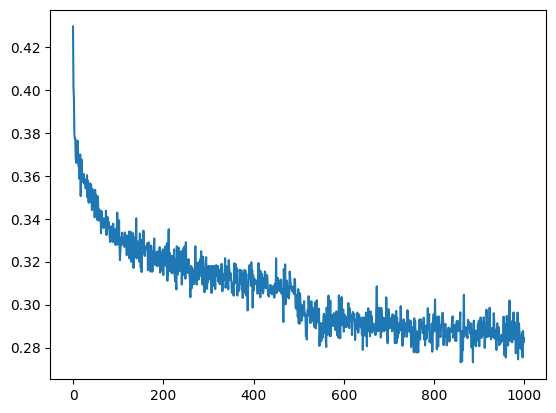

In [74]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [75]:
wavenet_model.eval()
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.8900049924850464
Validation Loss: 2.0027050971984863


## Possibility 5: Increase emb_dim to 30, 60

In [81]:
torch.manual_seed(42)

n_embd = 60
hidden_dim = 128
vocab_size = len(stoi)

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 86767


In [82]:
wavenet_model.train()

In [83]:
# training loop

n_iters = 200000
batch_size = 32
lr_scheduler = lambda i: 0.10 if i<100000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 20000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/200000 --> 3.295696258544922
Step 20000/200000 --> 1.906390905380249
Step 40000/200000 --> 1.9405487775802612
Step 60000/200000 --> 1.8120783567428589
Step 80000/200000 --> 1.90577232837677
Step 100000/200000 --> 2.123547077178955
Step 120000/200000 --> 2.0990288257598877
Step 140000/200000 --> 1.5199693441390991
Step 160000/200000 --> 2.032400369644165
Step 180000/200000 --> 1.8277521133422852


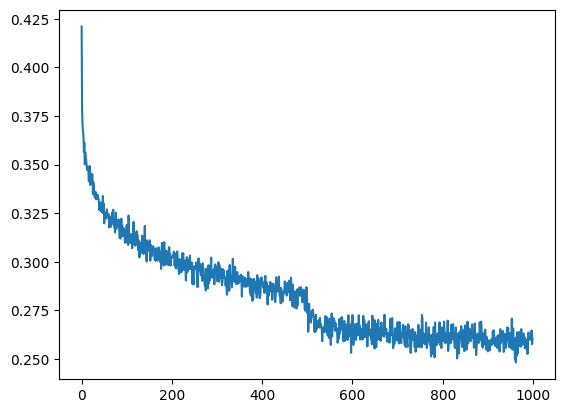

In [84]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [85]:
wavenet_model.eval()
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.7790764570236206
Validation Loss: 1.9884485006332397


## Possibility 5: Increase hidden_dim to 256, 512

In [124]:
torch.manual_seed(42)

n_embd = 60
hidden_dim = 256
vocab_size = len(stoi)

wavenet_model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model.num_params()}")

No. of parameters in the model: 302959


In [125]:
wavenet_model.train()

In [126]:
# training loop

n_iters = 60000
batch_size = 128
lr_scheduler = lambda i: 0.10 if i<30000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model.zero_grad()
    loss.backward()
    wavenet_model.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/60000 --> 3.3065009117126465
Step 10000/60000 --> 1.9611319303512573
Step 20000/60000 --> 1.8990013599395752
Step 30000/60000 --> 1.6025810241699219
Step 40000/60000 --> 1.9059470891952515
Step 50000/60000 --> 1.6349999904632568


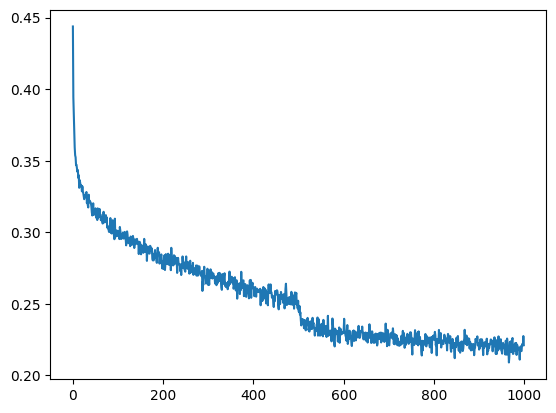

In [127]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [128]:
wavenet_model.eval()
train_loss = compute_loss(wavenet_model, X_train, y_train)
val_loss = compute_loss(wavenet_model, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.6448835134506226
Validation Loss: 2.0036461353302


## Best Model!!!

In [130]:
torch.manual_seed(42)

n_embd = 60
hidden_dim = 256
vocab_size = len(stoi)

wavenet_model_best = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.01), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]
)

# reduce confidence of the last layer
wavenet_model_best[-1].W.data *= 0.10

print(f"No. of parameters in the model: {wavenet_model_best.num_params()}")

No. of parameters in the model: 302959


In [131]:
wavenet_model_best.train()

In [132]:
# training loop

n_iters = 40000
batch_size = 128
lr_scheduler = lambda i: 0.10 if i<20000 else 0.01

stepi, lossi = [], []

for i in range(n_iters):
    batch = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[batch], y_train[batch]

    logits = wavenet_model_best(Xb)

    loss = torch.nn.functional.cross_entropy(logits, yb)

    wavenet_model_best.zero_grad()
    loss.backward()
    wavenet_model_best.update_params(lr=lr_scheduler(i))

    stepi.append(i)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f"Step {i}/{n_iters} --> {loss.item()}")
    # break

Step 0/40000 --> 3.3065009117126465
Step 10000/40000 --> 1.9611320495605469
Step 20000/40000 --> 1.8990012407302856
Step 30000/40000 --> 1.58141028881073


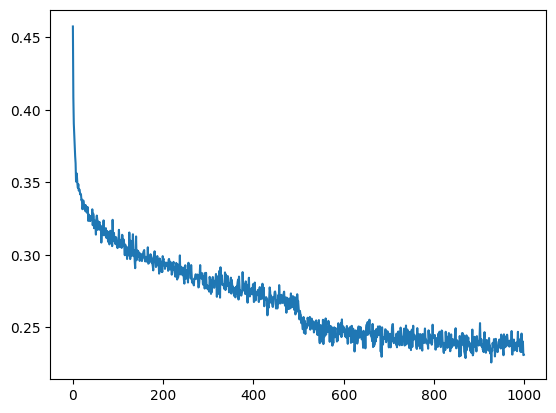

In [133]:
lossi = torch.FloatTensor(lossi)
lossi = lossi.view(1000, -1)
plt.plot(range(1000), lossi.mean(dim=1, keepdim=True).view(-1).log10())

In [134]:
wavenet_model_best.eval()
train_loss = compute_loss(wavenet_model_best, X_train, y_train)
val_loss = compute_loss(wavenet_model_best, X_val, y_val)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 1.715743899345398
Validation Loss: 1.9799154996871948


In [135]:
test_loss = compute_loss(wavenet_model_best, X_test, y_test)

print(f"Test Loss: {test_loss}")

Test Loss: 1.97200608253479


In [139]:
# sample from this best model

torch.manual_seed(42)

wavenet_model_best.eval()

for i in range(20):
    curr_seq, curr_name = [0] * block_size, ""

    while True:
        inp = torch.LongTensor(curr_seq).view(1, -1)
        logits = wavenet_model_best(inp)
        probs = torch.softmax(logits, dim=1).squeeze()
        next_char_idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        next_char = itos[next_char_idx]

        if next_char == '.':
            break
        curr_name += next_char
        curr_seq.append(next_char_idx)
        curr_seq = curr_seq[1:]

    print(curr_name)

anuel
nvi
symari
nehemiah
amilla
melah
mahela
lennix
callen
dmiya
jack
jordon
kalli
mikolyn
adhviki
eacha
kaithan
tiyan
marlee
niela


# Performance tracker

## Andrej hyperparams:
- n_embd = 24
- hidden_dim = 128
- block_size = 8 
- n_iters = 200000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<150000 else 0.01
- Train Loss: 1.7658894062042236
- Validation Loss: 1.9923888444900513

## Make BS 16:
- n_embd = 24
- hidden_dim = 128
- block_size = 8 
- n_iters = 200000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<150000 else 0.01
- Train Loss: 1.704831600189209
- Validation Loss: 2.034611225128174 (overfit :))

## More epochs on Andrej params
- n_embd = 24
- hidden_dim = 128
- block_size = 8 
- n_iters = 300000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<150000 else 0.01
- Train Loss: 1.7463939189910889
- Validation Loss: 1.9993618726730347

## Slash lr quickly
- n_embd = 24
- hidden_dim = 128
- block_size = 8 
- n_iters = 200000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<100000 else 0.01
- Train Loss: 1.7847299575805664
- Validation Loss: 1.9904942512512207

## Batch size increase to 64, 128, 256, 512
- n_embd = 24
- hidden_dim = 128
- block_size = 8
- n_iters = 200000
- batch_size = [64, 128, 256, 512]
- lr_scheduler = lambda i: 0.10 if i<100000 else 0.01
- Train Loss: [1.6894687414169312, ]
- Validation Loss: [2.0271575450897217, ]
- Incrase batch size overfits my model

## Increase emb dim
- n_embd = [30, 60]
- hidden_dim = 128
- block_size = 8
- n_iters = 200000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<100000 else 0.01
- Train Loss: [1.7832823991775513, 1.7790764570236206]
- Validation Loss: [1.9928606748580933, 1.9884485006332397]

## Increase hidden dim
- n_embd = 60
- hidden_dim = [256, 512]
- block_size = 8
- n_iters = 200000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<100000 else 0.01
- Train Loss: [1.6902626752853394, 1.6295212507247925]
- Validation Loss: [1.9943400621414185, 2.017216444015503]
- Overfit

## Now lets increase batch size
- n_embd = 60
- hidden_dim = 512
- block_size = 8
- n_iters = 40000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<20000 else 0.01
- Train Loss: 1.6421374082565308
- Validation Loss: 1.9865202903747559

## Best Model Yay !!!
- n_embd = 60
- hidden_dim = 256
- block_size = 8
- n_iters = 40000
- batch_size = 32
- lr_scheduler = lambda i: 0.10 if i<20000 else 0.01
- Train Loss: 1.715743899345398
- Validation Loss: 1.9799154996871948
- Test Loss: 1.97200608253479